# Predict the next seen movies

> The goal of this project is to validate your skills learned during the previous tutorials with the PySpark distributed computing software. You will build and test several implementations of recommendation systems. Here are the parts of the project:
> 
> * Part A: Load and preprocess the dataset. 
> * Part B: Build a first set of recommendation algorithms: naive with recurring pairs, a priori, and fp-growth to infer rules from a dataset.
> * Part C: Implement the PLSI algorithm ("Probabilistic Latent Semantic Indexing"), which is one way to create embeddings from a dataset. These embeddings can be used to fuel a recommendation engine.
> * Part D: Predict the next movies seen by a user in function of the last movies that he/she has seen with the previous implemented algorithms.

# Setup

## Install Spark Environment

> Since you are running on Google Colab, you will need to install Spark by ourselves, every time we run a new session. You need to install Spark, as well as a Java Runtime Environment.  Then you need to setup a few environment variables.

In [1]:
! pip install --upgrade pip
! pip install pyspark

^C
ERROR: Operation cancelled by user


Create and launch a Spark session with:

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

conf = SparkConf().set('spark.ui.port', '4050')

"""spark = SparkSession.builder.config(conf=conf) \
    .master('local[*]') \
    .getOrCreate()
"""

spark = SparkSession.builder \
    .appName("Movie Recommendations") \
    .config("spark.executor.memory", "4g") \
    .config("spark.executor.memoryOverhead", "1g") \
    .config("spark.memory.fraction", "0.6") \
    .config("spark.memory.storageFraction", "0.5") \
    .getOrCreate()

sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/13 23:25:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/13 23:25:58 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
spark

/!\ The Spark UI link is not accessible. Use the optional next session if you want to access it.

Uncomment and execute the following line, if you want to close and stop the created Spark session 

In [3]:
#spark.stop()

## Optional step: Enable Spark UI access through a secure tunnel

> This step is useful if you want to look at Spark UI.
First, you need to create a free ngrok account : https://dashboard.ngrok.com/login.  
Then connect on the website and copy your AuthToken.

In [4]:
# !uname -a

In [5]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip

In [6]:
#!./ngrok authtoken '2HYfdysedjgB5lcoeE8lqqShgIe_sZUm49MquX5okpssVMYQ' # <-------------- change this line !

In [7]:
#get_ipython().system_raw('./ngrok http 4050 &')

In [8]:
"""import json
import urllib

ngrok_tunnels = urllib.request.urlopen('http://localhost:4040/api/tunnels').read().decode('utf8')
spark_ui_url = json.loads(ngrok_tunnels)['tunnels'][0]['public_url']
print("Spark UI:", spark_ui_url)"""

'import json\nimport urllib\n\nngrok_tunnels = urllib.request.urlopen(\'http://localhost:4040/api/tunnels\').read().decode(\'utf8\')\nspark_ui_url = json.loads(ngrok_tunnels)[\'tunnels\'][0][\'public_url\']\nprint("Spark UI:", spark_ui_url)'

## Other Imports

In [9]:
import sys
import urllib.request as req
import zipfile
import glob
from datetime import datetime
from fractions import Fraction
from decimal import Decimal

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from pyspark import StorageLevel
from pyspark.sql import Row
from pyspark.sql import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StructType, StructField, StringType, IntegerType
from pyspark.sql.window import Window

In [10]:
import matplotlib.pyplot as plt

plt.style.use('default')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=18)
plt.rc('axes', titlesize=18)
plt.rc('axes', labelsize=18)
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('legend', fontsize=18)
plt.rc('lines', markersize=10)

# Part A - Dataset (5 points)

## Loading the dataset

In [12]:
url = 'http://files.grouplens.org/datasets/movielens/ml-20m.zip'
filehandle, _ = req.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
zip_file_object.namelist()
zip_file_object.extractall()

In [13]:
!find ml-20m -type f

ml-20m/links.csv
ml-20m/tags.csv
ml-20m/genome-tags.csv
ml-20m/ratings.csv
ml-20m/README.txt
ml-20m/genome-scores.csv
ml-20m/movies.csv


In [14]:
movies_path = "ml-20m/movies.csv"
ratings_path = "ml-20m/ratings.csv"

In [15]:
ratings_df_csv = spark.read.options(header=True, inferSchema=True).csv(ratings_path)
movies_df_csv = spark.read.options(header=True, inferSchema=True).csv(movies_path)

In [16]:
ratings_df_csv

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

In [17]:
ratings_df_csv

DataFrame[userId: int, movieId: int, rating: double, timestamp: int]

## Preprocessing

> In the following sections, we will work with algorithms that may scale more or less well with the size of the dataset. In this section we will develop several functions that will allow you to sample the dataset. Then in the next part of the notebook, it will be up to you to choose which tools you want to apply to your dataset in order to train your models, knowing that we want to have reasonable processing times (in the order of a minute), while having models that 'work' well.
>
> **Test all the functions that process the dataframe on a toy example, like what is done in first data processing question.**

### Question A1

>Write the *ratings_df_csv* and *movies_df_csv* DataFrame in a compressed parquet format.
>
>Reload them from parquet, to make next computations faster.

In [18]:
ratings_df_csv.write.parquet("ratings.parquet", compression="gzip")
movies_df_csv.write.parquet("movies.parquet", compression="gzip")

ratings_df = spark.read.parquet("ratings.parquet")
movies_df = spark.read.parquet("movies.parquet")

24/02/13 23:27:52 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


### Question A2

> Compute an estimation of the whole *ratings_df* dataset size in memory.
>
>Find the amount of partitions used by *ratings_df*.
>
>We try to have partitions not too big (in order not to crash our executors), and not to small (dealing with too many small partitions can lead to issues, on driver side for example). For this reason, a rule of thumb to have partitions of 128MB is okay. Given this, what do you think of the dataframe? Is the amount of partitions okay? Or should we repartition it? What would be the function to use if we need to repartition the dataframe?

In [19]:
ratings_df.rdd.getNumPartitions()

8

### Question A3

>Create a function named *remove_bad_ratings* that takes a rating dataframe as an argument, and returns a dataframe whose ratings are greater or equals to a rating_threshold, with default value of *3.5*.

In [20]:
def remove_bad_ratings(ratings_df, rating_threshold=3.5):
    return ratings_df.filter(ratings_df.rating >= rating_threshold)

In [21]:
ratings_removed_bad_ratings = remove_bad_ratings(ratings_df)
ratings_removed_bad_ratings.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|      2|   3.5|1112486027|
|     1|     29|   3.5|1112484676|
|     1|     32|   3.5|1112484819|
|     1|     47|   3.5|1112484727|
|     1|     50|   3.5|1112484580|
|     1|    112|   3.5|1094785740|
|     1|    151|   4.0|1094785734|
|     1|    223|   4.0|1112485573|
|     1|    253|   4.0|1112484940|
|     1|    260|   4.0|1112484826|
|     1|    293|   4.0|1112484703|
|     1|    296|   4.0|1112484767|
|     1|    318|   4.0|1112484798|
|     1|    337|   3.5|1094785709|
|     1|    367|   3.5|1112485980|
|     1|    541|   4.0|1112484603|
|     1|    589|   3.5|1112485557|
|     1|    593|   3.5|1112484661|
|     1|    919|   3.5|1094785621|
|     1|    924|   3.5|1094785598|
+------+-------+------+----------+


### Question A4

>Create a function named *sample_users* that takes a rating dataframe as an argument, and returns a dataframe with only a *ratio* of users (we want to keep all ratings from users that we keep) ; default value of *ratio* parameter is *0.1*. Function should be deterministic.

In [22]:
def sample_users(ratings_df, ratio=0.1):
    return ratings_df.sample(False, ratio, seed=42)


ratings_sampled_users = sample_users(ratings_df)
ratings_sampled_users.show()

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    223|   4.0|1112485573|
|     1|    589|   3.5|1112485557|
|     1|    653|   3.0|1094785691|
|     1|   1291|   3.5|1112485525|
|     1|   1374|   4.0|1094785746|
|     1|   1848|   3.5|1112486032|
|     1|   1994|   3.5|1094786087|
|     1|   2140|   4.0|1112485705|
|     1|   2288|   4.0|1094786077|
|     1|   2716|   3.5|1094786012|
|     1|   2762|   4.0|1112485367|
|     1|   3265|   3.5|1112484525|
|     1|   3476|   3.5|1094786139|
|     1|   3479|   4.0|1112485734|
|     1|   3889|   4.0|1112486138|
|     1|   4571|   4.0|1112485880|
|     1|   4915|   3.0|1112486076|
|     1|   5679|   3.5|1094786108|
|     1|   5898|   3.5|1112486002|
|     2|      3|   4.0| 974820889|
+------+-------+------+----------+


### Question A5

> Create a function named *remove_exotic_movies*, taking a rating dataframe as argument, and that removes all movies which have less than *nb_min_ratings* ; *nb_min_ratings* parameter has a default value of *1000*.

In [23]:
def remove_exotic_movies(ratings_df, nb_min_ratings=1000):
    return ratings_df.groupBy("movieId").count().filter(F.col("count") >= nb_min_ratings).join(ratings_df, "movieId",
                                                                                               "inner")


ratings_removed_exotic_movies = remove_exotic_movies(ratings_df)
ratings_removed_exotic_movies.show()

+-------+-----+------+------+----------+
|movieId|count|userId|rating| timestamp|
+-------+-----+------+------+----------+
|   3997| 2047|     1|   3.5|1112486192|
|   1580|35580|     2|   4.0| 974820748|
|   3918| 1246|     2|   3.0| 974820943|
|   2366| 6627|     3|   4.0| 944918310|
|   1580|35580|     7|   3.0|1011206832|
|   3175|13945|     7|   2.0|1011206805|
|   4519| 1936|     9|   2.0| 994019800|
|   1580|35580|    11|   5.0|1230788734|
|   1591| 5255|    11|   5.0|1230782724|
|    471|11268|    14|   5.0|1225308771|
|   1580|35580|    14|   3.5|1225319912|
|   3175|13945|    14|   4.5|1225320332|
|  36525| 1169|    14|   4.5|1225311849|
|  44022| 2465|    14|   4.0|1225310443|
|   1580|35580|    16|   4.0| 990970213|
|   1580|35580|    17|   4.0| 979686312|
|   1580|35580|    18|   2.5|1236356556|
|   2866| 1407|    21|   3.0| 992188523|
|   1580|35580|    22|   3.0| 994638608|
|   1580|35580|    23|   5.0| 914458526|
+-------+-----+------+------+----------+


### Question A6

> Compute the following stats on the dataset:
> - Amount of distinct users
> - Amount of distinct movies
> - Total amount of ratings
> - Let r_u be the amount of ratings made by user u. Study the distribution of r_u over all users (quantiles, histogram...)

In [24]:
ratings_df.agg(F.countDistinct("userId").alias("distinct_users"),
               F.countDistinct("movieId").alias("distinct_movies"),
               F.count("*").alias("total_ratings")).show()

ratings_df.groupBy("userId").count().agg(F.min("count"), F.max("count"), F.avg("count"), F.stddev("count")).show()

+--------------+---------------+-------------+
|distinct_users|distinct_movies|total_ratings|
+--------------+---------------+-------------+
|        138493|          26744|     20000263|
+--------------+---------------+-------------+
+----------+----------+-----------------+------------------+
|min(count)|max(count)|       avg(count)|     stddev(count)|
+----------+----------+-----------------+------------------+
|        20|      9254|144.4135299257002|230.26725699673392|
+----------+----------+-----------------+------------------+


array([[<Axes: title={'center': 'count'}>]], dtype=object)

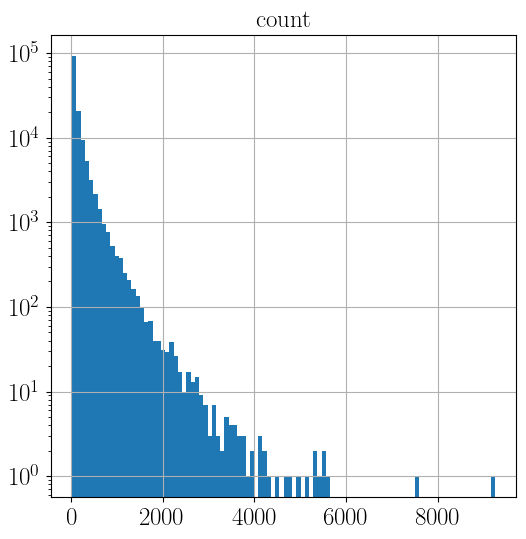

In [25]:
ratings_df.groupBy("userId").count().toPandas().hist("count", bins=100, figsize=(6, 6), log=True)

### Question A7

> Create a function named *remove_old_movies_in_timelines*, that takes a ratings dataframe as parameter, and only keeps the *nb_max_movies* most recent movies seen by each user ; *nb_max_movies* parameter is defaulted at 100.

In [26]:
def remove_old_movies_in_timelines(ratings_df, nb_max_movies=100):
    window = Window.partitionBy("userId").orderBy(F.desc("timestamp"))
    return ratings_df.withColumn("rank", F.rank().over(window)).filter(F.col("rank") <= nb_max_movies).drop("rank")


ratings_removed_old_movies_in_timelines = remove_old_movies_in_timelines(ratings_df)
ratings_removed_old_movies_in_timelines.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|    12|    231|   3.0|859064063|
|    12|    110|   4.0|859064062|
|    12|    364|   4.0|859064062|
|    12|    480|   3.0|859064062|
|    12|    527|   4.0|859064062|
|    12|    585|   3.0|859064062|
|    12|    595|   4.0|859064062|
|    12|    356|   4.0|859064001|
|    12|    208|   3.0|859064000|
|    12|    590|   3.0|859063999|
|    12|    589|   4.0|859063998|
|    12|     34|   4.0|859063997|
|    12|    344|   4.0|859063995|
|    12|    380|   4.0|859063994|
|    12|    104|   4.0|859063825|
|    12|    260|   4.0|859063825|
|    12|    376|   3.0|859063825|
|    12|    653|   4.0|859063825|
|    12|    784|   4.0|859063825|
|    12|    788|   4.0|859063825|
+------+-------+------+---------+


# Part B - Association Rules (5 points)

## Naive: Recurring pairs

> This approach is simple and not efficient but gives you a baseline and intuition for the next steps.
>
> Morally, what we want to do is:
> - for each user, regroup all the movies they have liked inside a single row. We will call this the 'user timeline'
> - for each user, generate all pairs of movies across their list of movies.
> - for each pair of movies, count the amount of distinct users with this pair.



### Question B1

> Create a function named *compute_timeline*, that takes a ratings dataframe as parameter, and returns the 'user timeline', a dataframe following this schema:
> - userId : integer
> - movies : list[integer] (list of movieId seen by user)
>
> Test it on a toy example.

In [27]:
def compute_timeline(ratings_df):
    return ratings_df.groupBy("userId").agg(F.collect_list("movieId").alias("movies"))


compute_timeline(ratings_df).show()

+------+--------------------+
|userId|              movies|
+------+--------------------+
|    12|[1, 3, 5, 6, 7, 1...|
|    26|[10, 19, 21, 22, ...|
|    27|[11, 29, 47, 104,...|
|    28|[150, 161, 165, 1...|
|    31|[1, 110, 260, 364...|
|    34|[1, 2, 7, 10, 15,...|
|    44|[260, 296, 349, 5...|
|    53|[1, 21, 29, 32, 4...|
|    65|[24, 318, 356, 36...|
|    76|[47, 110, 316, 48...|
|    78|[29, 110, 170, 19...|
|    81|[356, 480, 593, 7...|
|    85|[17, 262, 596, 89...|
|   101|[6, 10, 11, 19, 2...|
|   103|[7, 58, 186, 252,...|
|   108|[14, 16, 23, 32, ...|
|   115|[1, 22, 47, 88, 1...|
|   126|[1, 3, 5, 6, 14, ...|
|   133|[1, 6, 16, 32, 39...|
|   137|[1, 2, 6, 10, 15,...|
+------+--------------------+


### Question B2

> Let's imagine that all of our executors have 4GB of memory. If we consider the 'user timeline' dataset where movie ratings are greater or equal than 3.5, is it okay to store list of movie ids inside rows, as far as memory is concerned?

In [28]:
compute_timeline(remove_bad_ratings(ratings_df)).show()

+------+--------------------+
|userId|              movies|
+------+--------------------+
|    12|[1, 34, 36, 104, ...|
|    26|[21, 39, 47, 50, ...|
|    27|[11, 47, 104, 162...|
|    28|[213, 296, 356, 3...|
|    31|[110, 260, 616, 1...|
|    34|[1, 10, 17, 21, 3...|
|    44|[260, 296, 349, 5...|
|    53|[1, 21, 29, 32, 4...|
|    65|[24, 318, 356, 36...|
|    76|[47, 110, 480, 54...|
|    78|[29, 170, 198, 26...|
|    81|[356, 480, 593, 7...|
|    85|[17, 262, 596, 89...|
|   101|[6, 10, 11, 21, 2...|
|   103|[7, 252, 852, 902...|
|   108|[14, 32, 39, 111,...|
|   115|[47, 88, 296, 318...|
|   126|[1, 3, 5, 14, 62,...|
|   133|[1, 6, 16, 32, 47...|
|   137|[1, 6, 15, 70, 11...|
+------+--------------------+


### Question B3

> Create a function named *compute_pairs*, that takes a user timeline dataframe as parameter, and returns a dataframe of movie pairs (generated across all movies of their timeline) following this schema:
> - userId : integer
> - movieId1 : integer
> - movieId2 : integer
>
> You can rely on an udf to generate list of pair of movies from a list of movies.
> 
> Test it on a toy example.

In [29]:
def generate_pairs(movies):
    return [(movies[i], movies[j]) for i in range(len(movies)) for j in range(i + 1, len(movies))]


generate_pairs_udf = F.udf(generate_pairs, ArrayType(StructType([
    StructField("movieId1", IntegerType(), False),
    StructField("movieId2", IntegerType(), False)
])))

user_timeline_df = compute_timeline(remove_bad_ratings(ratings_df))
user_timeline_df = user_timeline_df.withColumn("moviePairs", generate_pairs_udf(F.col("movies")))

pairs_df = user_timeline_df.select(
    F.col("userId"),
    F.explode(F.col("moviePairs")).alias("pair")
).select(
    "userId",
    F.col("pair.movieId1").alias("movieId1"),
    F.col("pair.movieId2").alias("movieId2")
)

pairs_df.show()

+------+--------+--------+
|userId|movieId1|movieId2|
+------+--------+--------+
|    12|       1|      34|
|    12|       1|      36|
|    12|       1|     104|
|    12|       1|     110|
|    12|       1|     260|
|    12|       1|     344|
|    12|       1|     356|
|    12|       1|     364|
|    12|       1|     380|
|    12|       1|     527|
|    12|       1|     589|
|    12|       1|     595|
|    12|       1|     608|
|    12|       1|     653|
|    12|       1|     733|
|    12|       1|     784|
|    12|       1|     786|
|    12|       1|     788|
|    12|      34|      36|
|    12|      34|     104|
+------+--------+--------+


24/02/13 23:28:23 WARN PythonUDFRunner: Detected deadlock while completing task 0.0 in stage 42 (TID 109): Attempting to kill Python Worker


### Question B4

> Let's imagine that all of our executors have 4GB of memory. 
> 
> If we consider If we consider the 'user timeline where movie ratings are greater or equal than 3.5, what will happen when we generate pairs dataframe for this dataset ?
> 
> You need to consider:
> - amount of bytes retained by lists of pairs
> - amount of partitions we have in user timeline
>
> Also, consider what may happen because of skew. We may have all big user timelines inside same partition.

In [30]:
# Amount of bytes retained by lists of pairs
print(
    f'Amount of bytes retained by lists of pairs: {compute_timeline(remove_bad_ratings(ratings_df)).rdd.map(lambda x: sys.getsizeof(x[1])).sum()}')

Amount of bytes retained by lists of pairs: 107018480


In [31]:
# Amount of partitions we have in user timeline
print(
    f'Amount of partitions we have in user timeline: {compute_timeline(remove_bad_ratings(ratings_df)).rdd.getNumPartitions()}')

Amount of partitions we have in user timeline: 8



### Question B5

> Create a function named *compute_pair_frequencies*, that takes a movie pair dataframe as parameter, and returns a dataframe of movie pairs and their user count, following this schema:
> - movieId1 : integer
> - movieId2 : integer
> - count : integer
> 
> Dataframe should be **ordered**, with most frequent pairs first.
>
> Test it on a toy example.

In [34]:
def compute_pair_frequencies(movie_pair_df):
    # Group by movieId1 and movieId2, and count the occurrences
    pair_frequencies_df = movie_pair_df.groupBy("movieId1", "movieId2") \
        .count() \
        .withColumnRenamed("count", "userCount") \
        .orderBy(F.desc("userCount"))
    return pair_frequencies_df


toy = spark.createDataFrame([
    (100, 200, 1),
    (100, 300, 1),
    (200, 300, 2),
    (100, 200, 2),
    (400, 500, 1)
], ["movieId1", "movieId2", "userId"])

pair_frequencies_df = compute_pair_frequencies(toy.drop("userId"))

pair_frequencies_df.show()

ConnectionRefusedError: [Errno 61] Connection refused

### Question B6

> Quickly test the whole algorithm on *ratings_df* or a subset of it.
> 
> How many shuffles for the whole algorithm ?

In [35]:
user_timeline_df = compute_timeline(remove_bad_ratings(ratings_df))

ConnectionRefusedError: [Errno 61] Connection refused

## A priori

> You can find a good description of Apriori algorithm here:  
> https://en.wikipedia.org/wiki/Apriori_algorithm
>
> Some other resources:  
> [Apriori — Association Rule Mining In-depth Explanation and Python Implementation](https://towardsdatascience.com/apriori-association-rule-mining-explanation-and-python-implementation-290b42afdfc6)

### Question B7

> Implement your own version of A priori to compute most frequent pairs and quickly test it on *ratings_df* or a subset of it.
> 
> You may want to rely on *F.explode* as an alternative to udf.

### Question B8

> Implement your own version of A priori to compute most frequent triplets.
> 
> A this stage of the 'A priori' section, you are probably doing the same thing multiple times. 
> 
> Maybe it's time to factorize your code...

## 3. FP-Growth

> You can find a good description of FP-Growth algorithm with Spark here:  
> https://spark.apache.org/docs/latest/ml-frequent-pattern-mining.html
>
> Some other resources:  
[FP Growth — Frequent Pattern Generation in Data Mining with Python Implementation](https://towardsdatascience.com/fp-growth-frequent-pattern-generation-in-data-mining-with-python-implementation-244e561ab1c3)

### Question B9

> Use the Spark version of FP-Growth

# Part C - Probabilistic Latent Semantic Model (5 points)

> Aim of this section is to implement a Probabilistic Latent Semantic Model.
> 
> We will use an expectation maximization algorithm to learn its parameters.
>
> In the first set of questions you will implement some utility functions to deal with matrix manipulations.
>
> In the second set of questions, you will implement the algorithm itself.

## Matrix manipulation functions

> We will implement matrix operations that will be usefull to run the PLSI algorithm afterwards.

### Question CMatrix1

#### `matrix_sum_rows` 

> Takes a matrix (a column containing arrays of fixed length) and returns the sum of each row.

In [32]:
# Hint: https://stackoverflow.com/a/57448698/2015762
from prettytable import PrettyTable
from pyspark.sql.types import FloatType


def matrix_sum_rows(col_name, length_of_array):
    cols = [F.col(col_name)[i] for i in range(length_of_array)]
    return F.udf(lambda *xs: float(sum(xs)), FloatType())(*cols)


input_array = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
expected_output = input_array.sum(axis=1)
print('Input array')
print(input_array)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    spark.sparkContext.parallelize(input_array.tolist()).map(lambda x: Row(matrix=x)).toDF()
    .withColumn('row_sum', matrix_sum_rows('matrix', 4))
).show(truncate=False)

Input array
[[ 1.  2.  3.  4.]
 [40. 30. 20. 10.]]
Expected output
[ 10. 100.]
Obtained output
+------------------------+-------+
|matrix                  |row_sum|
+------------------------+-------+
|[1.0, 2.0, 3.0, 4.0]    |10.0   |
|[40.0, 30.0, 20.0, 10.0]|100.0  |
+------------------------+-------+


### Question CMatrix2

#### `matrix_sum_columns`

> Takes a matrix (a column containing arrays of fixed length) and returns the sum of each column.

In [46]:
# Hint: https://stackoverflow.com/a/54382990/2015762
from pyspark.sql.types import ArrayType, DoubleType


def matrix_sum_columns(col_name, length_of_array):
    pass


input_array = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
expected_output = input_array.sum(axis=0)
print('Input array')
print(input_array)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    spark.sparkContext.parallelize(input_array.tolist()).map(lambda x: Row(matrix=x)).toDF()
    .select(matrix_sum_columns('matrix', 4).alias('col_sum'))
).show(truncate=False)

Input array
[[ 1.  2.  3.  4.]
 [40. 30. 20. 10.]]
Expected output
[41. 32. 23. 14.]
Obtained output


AttributeError: 'NoneType' object has no attribute 'alias'

### Question CMatrix3

#### `matrix_normalize_rows`

> Takes a matrix (a column containing arrays of fixed length) and returns the same matrix where the rows have been divded by their sum, such that each row sums to 1.

In [ ]:
def matrix_normalize_rows(col_name, length_of_array):


input_array = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
expected_output = input_array / input_array.sum(axis=1).reshape(-1, 1)
print('Input array')
print(input_array)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    spark.sparkContext.parallelize(input_array.tolist()).map(lambda x: Row(numbers=x)).toDF()
    .withColumn('normalized_elements', matrix_normalize_rows('numbers', 4))
).show(truncate=False)

### Question CMatrix4

#### `matrix_elementwise_product`

> Takes two matrices and return their elementwise product (aka. Hadamard product)

In [ ]:
def matrix_elementwise_product(col_name_1, col_name_2, length_of_array):


input_array_1 = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
input_array_2 = np.array([[1, 2, 1, 2], [10, 20, 10, 20]], dtype=float)
expected_output = input_array_1 * input_array_2
print('Input array')
print(input_array_1)
print(input_array_2)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    spark.sparkContext.parallelize(zip(input_array.tolist(), input_array_2.tolist())).map(
        lambda x: Row(numbers_1=x[0], numbers_2=x[1])).toDF()
    .withColumn('elementwise_products', matrix_elementwise_product('numbers_1', 'numbers_2', 4))
).show(truncate=False)

### Question CMatrix5

#### `matrix_elementwise_divide`

> Takes two matrices and divide elementwise the first one by the second one.

In [ ]:
def matrix_elementwise_divide(col_name_1, col_name_2, length_of_array):


input_array_1 = np.array([[1, 2, 3, 4], [40, 30, 20, 10]], dtype=float)
input_array_2 = np.array([[1, 2, 1, 2], [10, 20, 10, 20]], dtype=float)
expected_output = input_array_1 / input_array_2
print('Input array')
print(input_array_1)
print(input_array_2)
print('Expected output')
print(expected_output)
print('Obtained output')
(
    spark.sparkContext.parallelize(zip(input_array.tolist(), input_array_2.tolist())).map(
        lambda x: Row(numbers_1=x[0], numbers_2=x[1])).toDF()
    .withColumn('elementwise_divided', matrix_elementwise_divide('numbers_1', 'numbers_2', 4))
).show(truncate=False)

## PLSI

> With
> * N the number of users u
> * M the number of movies s
> * L the number of latent classes z
> * T number of (user, movie) interactions (each interaction (s_t, u_t) means user u_t liked movie s_t)
>
>We suppose that the probability that a user will like a movie can be written in the form of a mixture model given by the equation:
$$
p(s|u) = \sum_{z=1}^L p(s|z) p(z|u)
$$
And we want to optimize the likelihood of the observed user interactions
$$
L = - \frac{1}{T} \sum_{1}^{T} \log p(s_t|u_t) = - \frac{1}{T} \sum_{1}^{T} \sum_{z=1}^L p(s_t|z) p(z|u_t)
$$
That can be done using an EM algorithm working as follow:
>
>**E step**
>
>For each interaction (u_t, s_t), compute for all z = 1, ..., L:
$$
p(z|(u_t, s_t)) = \frac{p(s_t|z) p(z|u_t)}{\sum_z p(s_t|z) p(z|u_t)}
$$
>
>**M step**
>
>Find each movie probability given a latent class
$$
p(s|z) = \frac{N(z, s)}{N(z)} 
\quad \text{where} \quad N(z, s) = \sum_s \sum_u p(z|(u, s)) 
\quad \text{and} \quad N(z) = \sum_s N(z, s)
$$
Find each latent class probability given each user.
$$
p(z|u) = \frac{\sum_s p(z|(u, s))}{\sum_z \sum_s p(z|(u, s))}
$$
>
>We will have the following dataframes
>
>* `count_z_s`: M rows, with columns  `movieId`, `N(z,s)`.
>* `count_z`: 1 row, with column `N(z)`.
>* `p_s_knowing_z`: M rows, with columns  `movieId`, `p(s|z)`. For a given z, the sum of p(s|z) equals 1.
>* `p_z_knowing_u`: N rows, with columns `userId`, `p(z|u)`. For a given u, the sum of p(z|u) equals 1.
>* `p_z_knowing_u_and_s`: N x M rows, with columns `userId`, `movieId`, `p(z|u,s)`.
>
> 
> Implement the PLSI algorithm

### Question CPLSI1.1

In [ ]:
def get_count_z(count_z_s, n_latent_classes):
    """Compute N(z) = sum_s N(z,s)
    """
    N_z_s = count_z_s.groupBy().agg(
        F.array(*[F.sum(F.col("N(z,s)")[i]) for i in range(n_latent_classes)]).alias("N(z)"))
    return N_z_s


count_z_s = ss.sparkContext.parallelize([
    st.Row(**{"movieId": 1, "N(z,s)": [1., 3., 4.]}),
    st.Row(**{"movieId": 2, "N(z,s)": [4., 5., 0.]}),
]).toDF()
get_count_z(count_z_s, 3).show()
# Expected [5., 8., 4.]

### Question CPLSI1.2

In [ ]:
def get_count_z_s(p_z_knowing_u_and_s, n_latent_classes):
    """Compute N(z,s) = sum_u p(z|u,s)
    """
    # ...
    pass

### Question CPLSI1.3

In [ ]:
def get_p_s_knowing_z(count_z_s, count_z, n_latent_classes):
    """Compute p(s|z) = N(z,s) / N(z)
    
    Hint: crossJoin may help
    """
    # ...
    pass

### Question CPLSI1.4

In [ ]:
def get_p_z_knowing_u(p_z_knowing_u_and_s, n_latent_classes):
    """Compute p(z|u) = sum_s p(z|u,s) / sum_z sum_s p(z|u,s)
    """
    # ...
    pass

### Question CPLSI1.5

In [ ]:
def get_p_z_knowing_u_and_s(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes):
    """For all pairs of observed (u, s)
    
    Compute p(z|u,s) = [N(z, s) / N(z) * p(z|u)] / sum_z [N(z, s) / N(z) * p(z|u)]
                     = [p(s|z) * p(z|u)] / sum_z [p(s|z) * p(z|u)]
    """
    # ...
    pass

### Question CPLSI1.6

In [ ]:
def log_likelihood(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes):
    """Compute the log likelihood of the observed pairs
    
    L = - 1 / T * sum_t log[ p(s|u) ]
      = - 1 / T * sum_t log[ sum_z p(s|z) * p(z|u) ]
    """
    # ...


pass

### Question CPLSI1.7

In [ ]:
def initialize_statistics(observed_pairs, n_latent_classes):
    """Initialize either p(s|z) and p(z|u) or p(z|(u, s)) to be able to fuel the first iteration of the EM algorithm.
    What would happen if you initialize these to a constant value ?
    """
    # ...
    pass

### Question CPLSI1.8

In [ ]:
def run_plsi(observed_pairs, n_iterations, n_latent_classes, checkpoint_every=1):
    start_init_time = time.time()
    spark.sparkContext.setJobDescription("Initialization")

    # ... = initialize_statistics(observed_pairs, n_latent_classes)
    llh = log_likelihood(observed_pairs,  # ... #, n_latent_class
                         mlflow.log_metric(key="llh", value=llh, step=0)
    print(f'LLH: {llh:.10f}')

    end_init_time = time.time()
    print(f'Initialization: {end_init_time - start_init_time:.1f}s')

    for i in range(n_iterations):
        start_e_step = time.time()
    spark.sparkContext.setJobDescription(f"Iteration {i + 1}: E-step")
    # E step
    # ...

    end_e_step = time.time()
    print(f'Iteration {i + 1}: E-step: {end_e_step - start_e_step:.1f}s')

    spark.sparkContext.setJobDescription(f"Iteration {i + 1}: M-step")
    # M step
    # ...

    llh = log_likelihood(observed_pairs, count_z_s, count_z, p_z_knowing_u, n_latent_classes)
    mlflow.log_metric(key="llh", value=llh, step=i + 1)

    end_m_step = time.time()
    print(f'Iteration {i + 1}: M-step: {end_m_step - end_e_step:.1f}s')
    print(f'LLH: {llh:.10f}')

    return get_p_s_knowing_z(count_z_s, count_z, n_latent_classes)

In [ ]:
!pip install -q mlflow

In [ ]:
import mlflow
import time

In [ ]:
n_iterations = 20
n_latent_classes = 5

with mlflow.start_run():
    mlflow.log_param("n_iterations", n_iterations)
    mlflow.log_param("n_latent_classes", n_latent_classes)
    run_plsi(ratings_df.sample(0.1), n_iterations=n_iterations, n_latent_classes=n_latent_classes)

### Question CPLSI2.1

> How does the EM algorithm is supposed to scale with the number of EM steps ? Do you observe such a scaling ?


### Question CPLSI2.2
> If each steap takes longer than the previous one: Try using .cache() wisely.

### Question CPLSI2.3

> Try to unpersist your dataframes when they become unneeded (look at the Storage tab in the Spark UI) (Optional + 2pts)

### Question CPLSI2.4

> If after few steps (typically 5), your algorithm starts being much slower and spend more and more time scheduling jobs (look in the Spark UI), try using [.localCheckpoint()](https://spark.apache.org/docs/2.1.0/api/python/pyspark.html#pyspark.RDD.localCheckpoint). How does it differ from caching ? What are the benefits and the drawbacks ?

# Part D - Test them all (5 points)

> In this section, we create training and test datasets, and test all the different prediction algorithms described above.



## Training and Testing datasets

### Question D1

> Create the training dataset named *training_df*. It is made of raw ratings dataframe, where:
> - *hash(userId) % 2 == 0*
> - and *rating >= 3.5*
> 
> You should rely on functions written in Part A.
> 
> Persist it on disk.

### Question D2

> Create a function named *create_test_df*, that creates a test dataset from a ratings dataframe ; it only retain the following records:
> - hash(userId) % 2 == 1
> - rating >= 3.5
> 
> Also, the function returns a dataframe structured like this:
> - userid : the user id
> - movies : list[integer] (all the movies in the user timeline minus the *K* most recent ones)
> - label : list[integer] (all the *K* most recent movies in user timeline)
>
> *K* is parameter whose default value is 5.
> 
> Test the test dataset creation on a toy example.
> 
> Create the real test dataset from the whole movieLense dataset. Name it *test_df*. Persist it on disk.

In [ ]:
def create_test_df(ratings_df, K=5):
    return ratings_df.filter(F.col("userId") % 2 == 1).groupBy("userId").agg(
        F.collect_list("movieId").alias("movies")).withColumn("label", F.slice(F.col("movies"), -K, K)).withColumn(
        "movies", F.slice(F.col("movies"), 1, F.size(F.col("movies")) - K))


test_df = create_test_df(ratings_df)
test_df.show()
test_df.write.parquet("test.parquet", compression="gzip")
test_df = spark.read.parquet("test.parquet")
test_df.show()

### Question D3

> Use/adapt each of the algorithms defined in previous sections (naïve, a-priori, FP-growth, PLSI) to predict the 5 next movies that will be seen by the user based on previously seen movies.
> 
> Each algorithm can be 'trained' on *training_df* or a subset of it ; choose and justify.
> 
> For each algorithm, make a quick qualitative analysis, to see how relevant recommended movies are. You should rely on *movies_df* for this question.
>
> Then, compare the algorithms with the *test_df*, with metrics like *recall* and *precision at k* (define some methods that compute recall and precision at k from test dataframe and predictions dataframe parameters)